In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.constants import physical_constants
from scipy.stats import norm, poisson

from ries.constituents.isotope import Isotope
from ries.constituents.state import GroundState, State
from ries.constituents.element import natural_elements
from ries.resonance.voigt import Voigt
from ries.nonresonant.xrmac import load_xrmac_data, xrmac_fm2_per_atom
load_xrmac_data()

/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/xrmac.py:274: RuntimeWarning: divide by zero encountered in scalar divide
  xrmac_conversion=lambda xrmac: xrmac
/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/xrmac.py:274: RuntimeWarning: invalid value encountered in scalar divide
  xrmac_conversion=lambda xrmac: xrmac
/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/xrmac.py:298: UserWarning: X-ray mass attenuation coefficient (XRMAC) data for the following elements were not found in '/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/../nonresonant/nist_xrmac' and replaced by an analytical expression for the Compton-scattering cross section:
H, He, Li, Be, B, C, N, O, F, Ne, Na, Mg, Al, Si, P, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Kr, Rb, Sr, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, 

# Self-absorption experiments with polarized photon beams

## 1. Introduction

This notebook models a nuclear-resonance-fluorescence (NRF) based self-absorption (SAbs) experiment (for a general overview, see, e.g., Ref. [1], in particular Sec. 2.3.5 therein) to measure nuclear level widths.

In the 'classical' approach , SAbs experiments employ an absorption target and a scattering target [1][2][3] (see also `ries/notebooks/6Li.ipynb`).
Only the radiation emitted by the scattering target is detected.
By performing one measurement with the absorption target and another one without it, the absorption cross section of nuclear resonances can be measured.
Due to the small interaction probability, absorption targets in this type of experiment are usually relatively massive (several, and up to tens of grams per cm2 [2][3]) for nuclear physics experiments.

In order to use the allocated time more efficiently (a classical SAbs experiment takes more than twice the time of a standard NRF experiment) and reduce systematic uncertainties, Savran and Isaak [4] proposed a new method for SAbs experiments that uses two scattering targets and an absorber.
The first scattering target is placed upstream from the absorber in a separate detection setup, while the other one is downstream in another setup.
In this case, the first setup will see the unaffected resonant scattering, while the second setup will see a reduced count rate due to the effect of the absorber.
It is crucial for this method that the two setups only observe resonant scattering off their respective targets.
The Savran-Isaak method has the aforementioned advantages, but it requires two setups, a careful alignment, and -like the classical SAbs approach- it does not make use of the resonant scattering in the massive absorber target.

Here, another variant of the SAbs method is proposed, which uses only a single setup with two targets.
The first target ('central target') is mounted in the center of the detection setup as in a usual beam-on-target experiment, while the second target ('downstream target') is mounted further downstream.
The targets are irradiated at the same time, and the setup detects resonant scattering off both of them, which means that the material is used efficiently.
In order to distinguish the radiation coming from the targets, the present approach makes use of the angular distributions of the scattered photons in NRF experiments with a polarized photon beam [5].
This places an important restriction on the applicability of the method, because the angular distributions can only be expected to be strongly asymmetric for isotopes with even numbers of protons and neutrons.
Due to the properties of the angular distributions, the largest asymmetry is usually achieved between detectors in a cross-like arrangement at a polar angle of 90 degrees to the beam direction [1][5].
One of the main quantities to assess the efficiency of the experiment will therefore be the count-rate asymmetry between horizontal (parallel to the beam polarization plane) and vertical (perpendicular) detectors in the cross.

As a realistic example, this notebook investigates a SAbs experiment on the isotope 24Mg.
The goal is a precision measurement of the level widths of excited states around 10 MeV.
The propagation of uncertainty is done with the Monte Carlo "propagation of distributions" method suggested in Ref. [14].
For this reason, all quantities with a non-negligible uncertainty are defined as probability distribution from `scipy.stats`.

[1] A. Zilges *et al.*, Prog. Part. Nucl. Phys. **122** (2022) 103903 https://doi.org/10.1016/j.ppnp.2021.103903

[2] C. Romig, Investigation of Nuclear Structure with Relative Self-Absorption Measurements, Dissertation, TU Darmstadt (2015) (https://tuprints.ulb.tu-darmstadt.de/id/eprint/4446)

[3] U. Friman-Gayer *et al.*, Phys. Rev. Lett. **126** (2021) 102501 https://doi.org/10.1103/PhysRevLett.126.102501; arXiv:2005.07837 https://arxiv.org/bs/2005.07837

[4] D. Savran and J. Isaak, Nucl. Instrum. Meth. A **899** (2018) 28-31 https://doi.org/10.1016/j.nima.2018.05.018

[5] C. Iliadis and U. Friman-Gayer, Eur. Phys. J. A **57** (2021) 190 https://doi.org/10.1140/epja/s10050-021-00472-1

[6] https://www.nndc.bnl.gov/nudat3/ (accessed on 12/17/2021)

[7] G. Peckham, P. Phys. Soc. **90** (1967) 657-670 https://doi.org/10.1088/0370-1328/90/3/312

[8] https://en.wikipedia.org/wiki/Magnesium_oxide (accessed on 12/18/2021)

[9] A. D. Ayangeakaa, U. Friman-Gayer, and R. V. F. Janssens, Innovation News Network https://www.innovationnewsnetwork.com/nuclear-structure/10491/

[10] https://github.com/uga-uga/nutr (accessed on 12/18/2021)

[11] S. Agostinelli *et al.*, Nucl. Inst. Meth. A **506** (2003) 250-303 https://doi.org/10.1016/S0168-9002(03)01368-8; J. Allison *et al.*, IEEE T. Nucl. Sci., **53** (2006) 270-278 https://doi.org/10.1109/TNS.2006.869826; J. Allison *et al.*, Nucl. Inst. Meth. A **835** (2016) 186-225 https://doi.org/10.1016/j.nima.2016.06.125

[12] https://tunl.duke.edu/higs-pac-2021 (accessed on 12/18/2021); H. R. Weller et al., Prog. Part. Nucl. Phys. **62** (2009) 257-303 https://doi.org/10.1016/j.ppnp.2008.07.001

[13] J. H. Hubbell and S. M. Seltzer, Technical Report, NISTIR 5632, NIST (2004) https://dx.doi.org/10.18434/T4D01F

[14] Joint Committee for Guides in Metrology (JCGM), "GUM: Guide to the Expression of Uncertainty in Measurement, Evaluation of measurement data", JCGM 100:2008(E); JCGM, "GUM, Supplement 1 - Propagation of dustributions using a Monte Carlo method", JCGM 101:2008 https://www.bipm.org/en/committees/jc/jcgm/publications

## 2. Data

### 2.1 Isotope data

Functions to calculate branching ratios from relative intensities of gamma rays from the NuDat database [6]. The database gives the intensities normalized to the strongest transition.

In [4]:
def relative_intensity_to_branching_ratio(relative_intensities, relative_intensities_uncertainty=None):
    """Convert relative intensities to branching ratios
    
As opposed to relative intensities, which can have an arbitrary normalization, the sum of all
branching ratios is 1.

The uncertainties are propagated using first-order 'Gaussian' propagation of uncertainty.
    
Parameters
----------
relative_intensities: array of float
    Relative intensities of gamma rays emitted from an excited state.
relative_intensities_uncertainties: array of float
    Corresponding standard deviations. An array have the same dimension as the list 
    of intensities.

Returns
-------
branching_ratios: ndarray
    Branching ratios with the property `sum(branching_ratios) = 1`
branching_ratios_uncertainty: ndarray
    Corresponding standard deviations.
"""
    total_intensity = np.sum(relative_intensities)
    if relative_intensities_uncertainty is None:
        return relative_intensities/total_intensity

    uncertainties = np.zeros(len(relative_intensities))
    for i in range(len(relative_intensities)):
        uncertainty_expression = 0.
        for j in range(len(relative_intensities)):
            if i == j:
                uncertainty_expression += ((total_intensity-relative_intensities[i])*relative_intensities_uncertainty[j])**2
            else:
                uncertainty_expression += (relative_intensities[i]*relative_intensities_uncertainty[j])**2
        uncertainties[i] = np.sqrt(uncertainty_expression)

    return (relative_intensities/total_intensity, uncertainties/(total_intensity**2))

The `Isotope` object includes only the states of interest and their known decay branches.
All information in the following cell has been taken from the NuDat database [6] or from the database of `ries`.

In [15]:
# Constants
half_life_to_lifetime = 1./np.log(2.)
eV_to_MeV = 1e-6

# Total widths and branching ratios from NuDat
total_width_9828 = ( # in MeV, obtained from half life in femtoseconds
    physical_constants["reduced Planck constant in eV s"][0]
    /(330e-18*half_life_to_lifetime)*eV_to_MeV)
branching_ratios_9828, branching_ratios_9828_uncertainty = relative_intensity_to_branching_ratio(
    np.array([100., 30.3, 2.1]), np.array([2., 2., 0.5]))

total_width_9967 = ( # in MeV, obtained from half life in femtoseconds
    physical_constants["reduced Planck constant in eV s"][0]
    /(76e-18*half_life_to_lifetime)*eV_to_MeV)
branching_ratios_9967, branching_ratios_9967_uncertainty = relative_intensity_to_branching_ratio(
    np.array([100., 38.]), np.array([12., 6.]))

total_width_10712 = ( # in MeV, obtained from half life in femtoseconds
    physical_constants["reduced Planck constant in eV s"][0]
    /(24e-18*half_life_to_lifetime)*eV_to_MeV)
branching_ratios_10712, branching_ratios_10712_uncertainty = relative_intensity_to_branching_ratio(
    np.array([100., 28.]), np.array([5., 5.]))

# Level scheme
mg24 = Isotope(
    Z=12, A=24, amu=natural_elements[12].isotopes[24].amu,
    ground_state=GroundState("0^+_1", 0, 1),
    excited_states={
        "9828": State(
            "9828", 2, 1, 9.828,
            {
                "0^+_1": total_width_9828*branching_ratios_9828[0],
                "2^+_1": total_width_9828*branching_ratios_9828[1],
                "0^+_2": total_width_9828*branching_ratios_9828[2],
            }
        ),
        "9967": State(
            "9967", 2, 1, 9.96719,
            {
                "0^+_1": total_width_9967*branching_ratios_9967[0],
                "2^+_1": total_width_9967*branching_ratios_9967[1],
            }
        ),
        "10712": State(
            "10712", 2, 1, 10.71174,
            {
                "0^+_1": total_width_10712*branching_ratios_10712[0],
                "2^+_1": total_width_10712*branching_ratios_10712[1],
            }
        )
    }
)

### 2.2 Sample data

As a sample material, choose magnesium oxide (MgO, 'magnesia'), which is a common magnesium compound and less reactive than pure magnesium.

In [16]:
mg_number_fraction = 0.5 # Fraction of magnesium atoms in magnesia
mg24_abundance = norm(0.7899, 0.0001) # Fraction of 24Mg in natural magnesium. Uncertainty estimated to be in the last digit.
magnesia_abundance = norm(0.99, 0.01) # Fraction of magnesia in the target material. Uncertainty estimated to be in the last digit.
effective_temperature = norm(530., 0.01*530.) # Effective temperature of magnesia in K at standard conditions. Value and uncertainty derived from the experimental phonon density in Ref. [7]

target_radius = 0.5*0.0254*1e15 # Target radius in femtometers. The diameter is 1 inch.
target_area = norm(np.pi*target_radius**2, 2.*np.pi*target_radius**2*5e-3) # Target area in fm^2
magnesia_density = 3.0 # Density of magnesia in g/cm^3. Estimated from the value in Wikipedia [8]. Since the actual target will be in powder form, the density was rounded down from 3.6 g/cm^3.

### 2.3 Detection system data


In [17]:
# Simulations using a source with the angular distribution of a 0^+ -> 1^+ -> 0^+ cascade
efficiency_times_angular_distribution_parallel_center = 0.0005861
efficiency_times_angular_distribution_parallel_downstream = 0.00026875
efficiency_times_angular_distribution_perpendicular_center = 1.005e-05
efficiency_times_angular_distribution_perpendicular_downstream = 0.000158

# Simulations using an isotropic source
efficiency_center = 0.000472235
efficiency_downstream = 0.00017976

## 3. Model

This section defines the model for the relation between the total width $\Gamma$ and the observed effective parallel-perpendicular asymmetry $\bar{A}$ in the experiment. The asymmetry is given by:

$\bar{A} = \frac{\left(N_\parallel^c + N_\parallel^d\right)-\left(N_\perp^c + N_\perp^d\right)}{\left(N_\parallel^c + N_\parallel^d\right)+\left(N_\perp^c + N_\perp^d\right)}$

Here, $N_p^t$ denotes the number of events observed by the detector in the parallel ($p = \parallel$) or perpendicular ($p = \perp$) plane due to resonant scattering in the central ($t = c$) or the downstram ($t = d$) target.
Since it is impossible to determine the origin of a photon by just looking at a single detector, the counts have been added.
Each number of events is given by (see, e.g., the Supplemental Material of Ref. [3]):

$N_p^t = N_\gamma \bar{\epsilon}_p \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_p^t \langle \Phi^t \sigma \rho_A^t \rangle$

Here, the symbol $N_\gamma$ denotes the absolute normalization of the photon flux. 
The symbol $\bar{\epsilon}_p \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_p^t$ denotes angular correlation $w$ of radiation emitted from target position $t$, weighted by the solid-angle-dependent efficiency $\epsilon$ of detector $p$.
The efficiency is assumed to factor into a normalization constant $\bar{\epsilon}_p$ and the energy- and solid-angle dependent $\epsilon / \bar{\epsilon}_p^t$.
Please note that the normalization constant is independent of the target position.
The symbol $\langle \Phi^t \sigma \rho_A^t \rangle$ denotes the integral of the resonance absorption density (see, e.g., Ref. [1]) over the spatial extent of the target, symbolized by the product of the normalized photon flux $\Phi^t$ at the target position $t$, the scattering cross section $\sigma$, and the areal density of the target $\rho_A^t$.

The products of the efficiency and the angular correlation are measured in two separate runs in which only one of the two targets is present, resulting in four more measured quantities:

$N_p^{t,t} = N_\gamma^t \bar{\epsilon}_p \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle^t_p \langle \Phi^t \sigma \rho_A^t \rangle$

Here, the second indices on $N_p^{t,t}$ and $N_\gamma^t$ indicate which target was present.

In addition, two calibration measurements with a radioactive source at each target position are performed to fix the normalization of the efficiency, resulting in four more measured quantities:

$N_{p, \mathrm{cal}}^t = a \Delta t^t \bar{\epsilon}_p \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_p^t$

Here, $a$ denotes the activity of the source, and $\Delta t^{t}$ is the live time of the measurement.

Lastly, geometric effects (angular correlation, source dimensions) are assumed to be taken into 
account by Monte Carlo simulations.
While it is challenging to reproduce absolute efficiencies, such simulations usually describe 
relative quantities with sufficient precision.
Simulations with a radioactive source (index $\mathrm{sim}$) and with an extended target with 
an angular correlation (index $\mathrm{sim}, w$) can be interpreted as another counting experiment:

$N_{p, \mathrm{sim}}^t = \bar{\epsilon}_{p,\mathrm{sim}} \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_p^t$

$N_{p, \mathrm{sim}, w}^t = \bar{\epsilon}_{p,\mathrm{sim}} \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_p^t$

Please note that -as opposed to the photon flux in a real experiment- the number of simulated 
particles that is proportional to $\bar{\epsilon}_{p,\mathrm{sim}}$ can be chosen by the user.

With these additional measurements/simulations at hand, the variables in the definition of the effective asymmetry can be expressed in terms of known quantities.
Here, all quantities are normalized to the number of counts in the parallel detectors due to scattering off the central target.
That variable, expressed in its constituents, is:

$N_\parallel^c = N_\gamma \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c \langle \Phi^c \sigma \rho_A^c \rangle$

In order to convert the number of counts in the parallel detector due to scattering off the 
downstream target, the ratio of efficiencies with respect to an isotropic source 
from the source measurement is used, and it is converted to a ratio of efficiencies for radition
emitted by the target using the simulation:

$N_\parallel^d$

$= N_\gamma \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^d \langle \Phi^d \sigma \rho_A^d \rangle$

$= N_\gamma \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c \frac{\bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^d}{\bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c} \langle \Phi^d \sigma \rho_A^d \rangle$

$= N_\gamma
\bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c 
\underbrace{
    \frac{
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^d
    }
    {
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\parallel^d
    }
}_{
    \frac{N_{\parallel, \mathrm{sim}, w}^d}{N_{\parallel, \mathrm{sim}}^d}
}
\underbrace{
    \frac{
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\parallel^c
    }
    {
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c
    }
}_{
    \frac{N_{\parallel, \mathrm{sim}}^c}{N_{\parallel, \mathrm{sim}, w}^c}
}
\underbrace{
    \frac{
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\parallel^d
    }
    {
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\parallel^c
    }
}_{
    \frac{N_{\parallel, \mathrm{cal}}^d \Delta t^c}{N_{\parallel, \mathrm{cal}}^c \Delta t^d}
}
\langle \Phi^d \sigma \rho_A^d \rangle$

The number of counts in the perpendicular detector due to scattering off the central target is 
converted by using the count-rate ratio from the measurement with a single target at the central 
position:
    
$N_\perp^c$

$= N_\gamma \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^c \langle \Phi^c \sigma \rho_A^c \rangle$

$= N_\gamma \bar{\epsilon}_\parallel 
\langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c
\underbrace{
    \frac{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^c
    }
    {
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c
    }
}_{
    \frac{N_\perp^{c,c}}{N_\parallel^{c,c}}
}
\langle \Phi^c \sigma \rho_A^c \rangle$

At last, the number of counts in the perpendicular detector due to scattering off the downstream target is converted.
First, an analog conversion as for $N_\parallel^d$ is performed, using the radioactive-source calibration.
After that, the relation between the efficiency of the parallel and perpendicular detectors with respect to radiation coming from the central target is used (taking into account the geometric effects via simulations).

$N_\perp^d$

$= N_\gamma \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^d \langle \Phi^d \sigma \rho_A^d \rangle$ 

$= N_\gamma \bar{\epsilon}_\perp 
\langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c 
\underbrace{
    \frac{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^c
    }{
        \bar{\epsilon}_\parallel \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\parallel^c
    }
}_{
    \frac{N_\perp^{c,c}}{N_\parallel^{c,c}}
}
\underbrace{
    \frac{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^d
    }{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\perp^d    
    }
}_{
    \frac{N_{\perp, \mathrm{sim}, w}^d}{N_{\perp, \mathrm{sim}}^d}
}
\underbrace{
    \frac{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\perp^c    
    }{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} w \rangle_\perp^c
    }
}_{
    \frac{N_{\perp, \mathrm{sim}}^c}{N_{\perp, \mathrm{sim}, w}^c}
}
\underbrace{
    \frac{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\perp^d    
    }{
        \bar{\epsilon}_\perp \langle \frac{\epsilon}{\bar{\epsilon}} \rangle_\perp^c
    }
}_{
    \frac{N_{\perp, \mathrm{cal}}^d \Delta t^c}{N_{\perp, \mathrm{cal}}^c \Delta t^d}
}
\langle \Phi^d \sigma \rho_A^d \rangle
$

From these nine measured quantities $\bar{A}$, $\left\{ N_{p}^{t,t} \right\}$, and $\left\{N_{p,\mathrm{cal}}^t\right\}$, the unknown properties of the detection system can be eliminated, and the effective asymmetry becomes:

$\bar{A} = 
\frac{
    \left(
        \langle \Phi^c \sigma \rho_A^c \rangle 
        +\frac{N_{\parallel, \mathrm{sim}, w}^d}{N_{\parallel, \mathrm{sim}}^d}
        \frac{N_{\parallel, \mathrm{sim}}^c}{N_{\parallel, \mathrm{sim}, w}^c}
        \frac{N_{\parallel, \mathrm{cal}}^d \Delta t^c}{N_{\parallel, \mathrm{cal}}^c \Delta t^d}
        \langle \Phi^d \sigma \rho_A^d \rangle
    \right)
    -\left(
        \frac{N_\perp^{c,c}}{N_\parallel^{c,c}} \langle \Phi^c \sigma \rho_A^c \rangle  
        +\frac{N_\perp^{c,c}}{N_\parallel^{c,c}}
        \frac{N_{\perp, \mathrm{sim}, w}^d}{N_{\perp, \mathrm{sim}}^d}
        \frac{N_{\perp, \mathrm{sim}}^c}{N_{\perp, \mathrm{sim}, w}^c}
        \frac{N_{\perp, \mathrm{cal}}^d \Delta t^c}{N_{\perp, \mathrm{cal}}^c \Delta t^d}
        \langle \Phi^d \sigma \rho_A^d \rangle
    \right)
}
{
    \left(
        \langle \Phi^c \sigma \rho_A^c \rangle 
        +\frac{N_{\parallel, \mathrm{sim}, w}^d}{N_{\parallel, \mathrm{sim}}^d}
        \frac{N_{\parallel, \mathrm{sim}}^c}{N_{\parallel, \mathrm{sim}, w}^c}
        \frac{N_{\parallel, \mathrm{cal}}^d \Delta t^c}{N_{\parallel, \mathrm{cal}}^c \Delta t^d}
        \langle \Phi^d \sigma \rho_A^d \rangle
    \right)
    +\left(
        \frac{N_\perp^{c,c}}{N_\parallel^{c,c}} \langle \Phi^c \sigma \rho_A^c \rangle  
        +\frac{N_\perp^{c,c}}{N_\parallel^{c,c}}
        \frac{N_{\perp, \mathrm{sim}, w}^d}{N_{\perp, \mathrm{sim}}^d}
        \frac{N_{\perp, \mathrm{sim}}^c}{N_{\perp, \mathrm{sim}, w}^c}
        \frac{N_{\perp, \mathrm{cal}}^d \Delta t^c}{N_{\perp, \mathrm{cal}}^c \Delta t^d}
        \langle \Phi^d \sigma \rho_A^d \rangle
    \right)
}$

The terms $\langle \Phi^t \sigma \rho_A^t \rangle$ depend on the ...

 * ... areal densities $\rho_A^t$ of both targets, expressed here by the measurable masses $m^t$ and the target areas $A^t$:
 
$\rho_A^t = \frac{m^t}{A^t}$
 
 * ... enrichment $c_\mathrm{MgO}$ of the target material in magnesia
 * ... enrichment $c_{^{24}\mathrm{Mg}}$ of the target material in $^{24}$Mg
 * ... mass attenuation coefficient $\mu$ of magnesia
 * ... effective temperature $T_\mathrm{eff}$ of magnesia
 * ... (mass $m_{^{24}\mathrm{Mg}}$ of the isotope of interest)
 * ... excitation energy $E_x$ of the state of interest
 * ... ground-state branching ratio $\Gamma_0 / \Gamma$
 * ... total width $\Gamma$
 
That relation, which is implemented below, is given in Refs. [1][2], and [3].

In [27]:
class PolarizedSAbsMagnesia:
    """Model for a polarized self-absorption experiment on 24Mg in a magnesium compound"""

    def areal_density(self, mass, A):
        """Calculate areal density of atoms from input in commonly used units and convert to microscopic units.

Parameters
----------
mass: float
    Mass in kg
A: float
    Area in fm^2

Returns
-------
float
    Areal density in number of atoms per fm^2.
    """
        # Factor of two, because every "molecule" has two atoms
        return 2.*mass/((natural_elements[12].amu()+natural_elements[6].amu())*physical_constants["atomic mass constant"][0]*A)
        
    def mu(self, energy):
        """Nonresonant scattering cross section for magnesia

The attenuation coefficient / cross section for the compound magnesia is an atomic-mass-weighted 
combination of the attenuation coefficients of magnesium and oxygen [13].

Parameters
----------
energy: float or ndarray
    Energy in MeV

Returns
-------
float or ndarray
    Scattering cross section in fm^2 per atom.
"""
        return (
            natural_elements[12].amu()
            /(natural_elements[12].amu()+natural_elements[6].amu())*xrmac_fm2_per_atom[12](energy)
            +natural_elements[6].amu()
            /(natural_elements[12].amu()+natural_elements[6].amu())*xrmac_fm2_per_atom[6](energy)
    )
    
    def integrand(self, energy, areal_density_limits, cross_section, mg24_abundance, magnesia_abundance):
        """Residual energy dependence of the resonance absorption density after integrating over the spatial coordinate

The resonance absorption density describes the energy- and position-dependent cross section for
the resonant absorption of a photon [1].
Assuming that the same approximations as in Ref. [3] are valid, the integration over the space
coordinate has been executed analytically.
Although the `magnesia_abundance` parameter allows the target material to contain impurities,
it is assumed that the impurities contribute to the nonresonant absorption in the same way as
magnesia.
Due to the low impact of the atomic attenuation for this low-Z target and its high purity, this is 
expected to be a good approximation.

Parameters
----------
energy: float or ndarray
    Energy in MeV

Returns
-------
float or ndarray
    Resonance absorption density integrated over the spatial coordinate.
    This quantity is dimensionless.
"""
        sigma = mg_number_fraction*mg24_abundance*magnesia_abundance*cross_section(energy)
        mu_plus_sigma = self.mu(energy)+sigma
        return (
            sigma/mu_plus_sigma
            *(
                np.exp(
                    -mu_plus_sigma*areal_density_limits[0]
                )
                - np.exp(
                    -mu_plus_sigma*areal_density_limits[1]
                )
            )
        )
    
    def effective_asymmetry(
        self,
        excitation_energy, ground_state_branching_ratio, total_width, # Isotope data
        effective_temperature, target_mass_center, target_area_center, target_mass_downstream, # Sample data
        target_area_downstream, mg24_abundance, magnesia_abundance, 
        N_parallel_center, N_perpendicular_center, # Measurement with linear polarization and central target only
        #N_parallel_downstream, N_perpendicular_downstream, # Measurement with linear polarization and downstream target only (not needed)
        N_parallel_center_iso, N_perpendicular_center_iso, # Measurement with isotropic source at central target position
        N_parallel_center_iso_sim, N_perpendicular_center_iso_sim, # Simulation with isotropic source at central target position
        N_parallel_center_sim, N_perpendicular_center_sim, # Simulation with angular distribution at central target position
        N_parallel_downstream_iso, N_perpendicular_downstream_iso, # Measurement with isotropic source at central target position
        N_parallel_downstream_iso_sim, N_perpendicular_downstream_iso_sim, # Simulation with isotropic source at downstream target position
        N_parallel_downstream_sim, N_perpendicular_downstream_sim, # Simulation with angular distribution at downstream target position
    ):

        # Set up isotope
        isotope = Isotope(
            Z=12, A=24, amu=natural_elements[12].isotopes[24].amu,
            ground_state=GroundState("ground_state", 0, 1),
            excited_states={
                "excited_state": State(
                    "excited_state", 2, 1,
                    excitation_energy,
                    {
                        "ground_state": ground_state_branching_ratio*total_width,
                        "inelastic": (1.-ground_state_branching_ratio)*total_width,
                    }
                )
            }
        )

        # Set up resonance cross section
        cross_section = Voigt(
            initial_state=isotope.ground_state,
            intermediate_state=isotope.excited_states["excited_state"],
            amu=isotope.amu,
            effective_temperature=effective_temperature,
            final_state=isotope.ground_state
        )

        # Calculate the number of resonantly scattered photons on the central and the downstream
        # target by integrating t:he resonance absorption density.
        areal_density_center = self.areal_density(target_mass_center, target_area_center)
        resonant_scattering_center = quad(
            lambda energy: self.integrand(
                energy, [0., areal_density_center], cross_section, mg24_abundance, magnesia_abundance),
            *cross_section.coverage_interval(0.999)
        )[0]
        resonant_scattering_downstream = quad(
            lambda energy: self.integrand(
                energy, [areal_density_center, areal_density_center+self.areal_density(target_mass_downstream, target_area_downstream)],
                                          cross_section, mg24_abundance, magnesia_abundance),
            *cross_section.coverage_interval(0.999)
        )[0]

        N_parallel_center_exp = resonant_scattering_center
        N_parallel_downstream_exp = (
            (N_parallel_downstream_sim/N_parallel_downstream_iso_sim)
            *(N_parallel_center_iso_sim/N_parallel_center_sim)
            *(N_parallel_downstream_iso/N_parallel_center_iso)
            *resonant_scattering_downstream
        )
        N_perpendicular_center_exp = (
            (N_perpendicular_center/N_parallel_center)
            *resonant_scattering_center
        )
        N_perpendicular_downstream_exp = (
            (N_perpendicular_center/N_parallel_center)
            *(N_perpendicular_downstream_sim/N_perpendicular_downstream_iso_sim)
            *(N_perpendicular_center_iso_sim/N_perpendicular_center_sim)
            *(N_perpendicular_downstream_iso/N_perpendicular_center_iso)
            *resonant_scattering_downstream
        )

        N_parallel_exp = N_parallel_center_exp + N_parallel_downstream_exp
        N_perpendicular_exp = N_perpendicular_center_exp + N_perpendicular_downstream_exp

        return (N_parallel_exp-N_perpendicular_exp)/((N_parallel_exp+N_perpendicular_exp))

## 4. Detector system data

In this section, the results of the calibration measurements / Monte Carlo simulations are listed.
For the detection system, assume an array of clover-type high-purity germanium detectors at 8 
inches target distance [9].
At the moment, all of the numbers below are the result of Monte Carlo particle simulations with 
the `nutr` application [10] that is based on the Geant4 framework [11]. Addback was used to 
maximize the detection efficiency.
All numbers are full-energy peak counts.

In [28]:
# Measurements with target at central position
N_parallel_center = poisson(8702+8572)
N_perpendicular_center = poisson(133+125)

# Measurements and simulations with isotropic source
N_parallel_center_iso = poisson(23661+23609+23805+23372)
N_perpendicular_center_iso = N_parallel_center_iso
N_parallel_center_iso_sim = N_parallel_center_iso
N_perpendicular_center_iso_sim = N_parallel_center_iso

N_parallel_downstream_iso = poisson(8916+8975+9019+9042)
N_perpendicular_downstream_iso = N_parallel_downstream_iso
N_parallel_downstream_iso_sim = N_parallel_downstream_iso
N_perpendicular_downstream_iso_sim = N_parallel_downstream_iso

# Simulations with extended source with angular correlation
N_parallel_center_sim = N_parallel_center
N_perpendicular_center_sim = N_perpendicular_center

N_parallel_downstream_sim = poisson(2673+2702)
N_perpendicular_downstream_sim = poisson(1562+1598)

## 5. Experiment optimization

In [29]:
excited_states = [mg24.excited_states["9828"], mg24.excited_states["9967"], mg24.excited_states["10712"]]

effective_asymmetry_values = []
for n_state, excited_state in enumerate(excited_states):
    effective_asymmetry_values.append([])
    target_mass_center_values = 10**np.linspace(-3., 0., 50) # in kg
    target_mass_downstream_values = ( # in kg, scaled by the relative efficiency of the detection system w.r.t. radiation coming from both target positions.
        (N_parallel_center_iso_sim.mean()+N_perpendicular_center_iso_sim.mean())
        /(N_parallel_downstream_iso_sim.mean()+N_perpendicular_downstream_iso_sim.mean())
        *target_mass_center_values
    )

    pol_sabs = PolarizedSAbsMagnesia()

    for n_mass in range(len(target_mass_center_values)):
        effective_asymmetry_values[n_state].append(
            pol_sabs.effective_asymmetry(
                excitation_energy=excited_state.excitation_energy,
                ground_state_branching_ratio=excited_state.partial_widths["0^+_1"]/excited_state.width,
                total_width=excited_state.width,
                effective_temperature=effective_temperature.mean(),
                target_mass_center=target_mass_center_values[n_mass],
                target_area_center=target_area.mean(),
                target_mass_downstream=target_mass_downstream_values[n_mass],
                target_area_downstream=target_area.mean(),
                mg24_abundance=mg24_abundance.mean(),
                magnesia_abundance=magnesia_abundance.mean(),
                N_parallel_center=N_parallel_center.mean(),
                N_perpendicular_center=N_perpendicular_center.mean(),
                N_parallel_center_iso=N_parallel_center_iso.mean(),
                N_perpendicular_center_iso=N_perpendicular_center_iso.mean(),
                N_parallel_center_iso_sim=N_parallel_center_iso_sim.mean(),
                N_perpendicular_center_iso_sim=N_perpendicular_center_iso_sim.mean(),
                N_parallel_center_sim=N_parallel_center_sim.mean(),
                N_perpendicular_center_sim=N_perpendicular_center_sim.mean(),
                N_parallel_downstream_iso=N_parallel_downstream_iso.mean(),
                N_perpendicular_downstream_iso=N_perpendicular_downstream_iso.mean(),
                N_parallel_downstream_iso_sim=N_parallel_downstream_iso_sim.mean(),
                N_perpendicular_downstream_iso_sim=N_perpendicular_downstream_iso_sim.mean(),
                N_parallel_downstream_sim=N_parallel_downstream_sim.mean(),
                N_perpendicular_downstream_sim=N_perpendicular_downstream_sim.mean()          
            )
        )

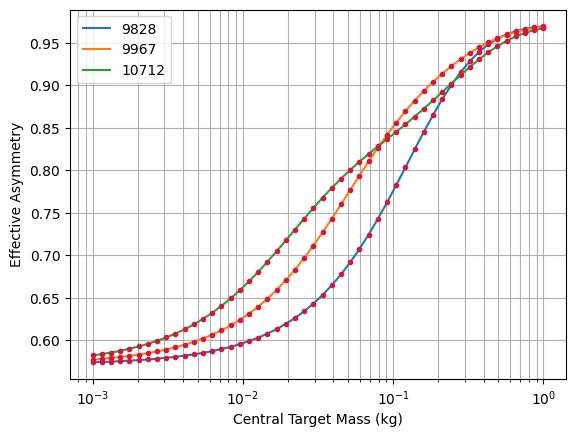

In [31]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Central Target Mass (kg)")
ax.set_ylabel("Effective Asymmetry")
for n_state, excited_state in enumerate(excited_states):
    ax.semilogx(target_mass_center_values, effective_asymmetry_values[n_state], "-", label=excited_state.J_pi)
    ax.semilogx(target_mass_center_values, effective_asymmetry_values[n_state], ".", color="crimson")
ax.grid(which="both")
ax.legend()
plt.savefig("asymmetry_vs_mass.pdf")